# Mar 3, 2025: check graphs
visualize them

In [1]:
import os
import glob
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from itertools import product, combinations
from sklearn.covariance import GraphicalLasso
from scipy.stats import entropy, zscore
from sklearn.metrics import mutual_info_score
from joblib import Parallel, delayed
import graph_tool.all as gt 
import seaborn as sns

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

np.random.seed(args.SEED)

In [3]:
args.source = 'allen' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #216 #334 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'l1o' #f'sub' #f'grp' #f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')

0

In [5]:
graph_files = glob.glob(f'{GRAPH_path}/*')
graph_files

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/graphs/sub-SLC07_task-rest_desc-graph.gt.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/graphs/sub-SLC06_task-rest_desc-graph.gt.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/graphs/sub-SLC08_task-rest_desc-graph.gt.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-l1o/graphs/sub-SLC09_task-rest_desc-graph.gt.g

In [6]:
graphs = [
    gt.load_graph(gfile)
    for gfile in graph_files
]
graphs

[<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc14150acf0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc1415165d0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc141516990>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc14158c050>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc14158c640>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc1415232f0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc14154d7b0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc14154d9d0>,
 <Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7fc141358350>]

In [7]:
def adjacency_matrix(g):
    A = np.zeros((g.num_vertices(), g.num_vertices()), dtype=int)
    edges = [list(edge) for edge in list(g.get_edges())]
    v1, v2 = list(zip(*edges))
    weights = list(g.ep['weight'])
    A[v1, v2] = weights
    A = (A + A.T)
    return A

As = [
    adjacency_matrix(g)
    for g in graphs
]

In [8]:
[A.shape for A in As]

[(172, 172),
 (172, 172),
 (172, 172),
 (172, 172),
 (172, 172),
 (172, 172),
 (172, 172),
 (172, 172),
 (172, 172)]

<Axes: >

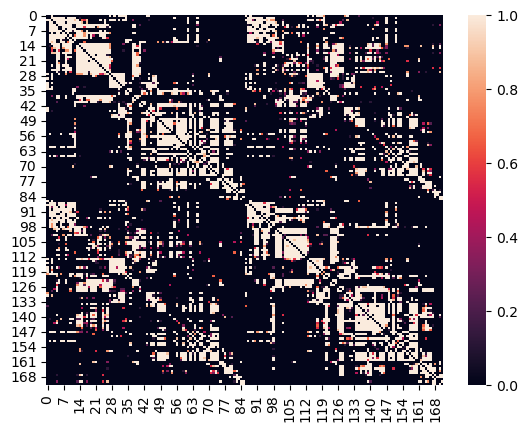

In [9]:
mean_A = np.mean(As, axis=0)
sns.heatmap(mean_A)